# Diffusion Model test

In [1]:
from schedules import linear_beta_schedule
timesteps = 200

In [2]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (/u/nyw6dh/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)


Parameter 'transform'=<function transforms at 0x7fa4ddba1bd0> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [5]:
transformed_dataset["train"]

Dataset({
    features: ['image'],
    num_rows: 60000
})

In [6]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [17]:
for i in dataloader:
    print(i['pixel_values'].max())
    break

tensor(1.)


In [ ]:
from torch.optim import Adam
from unet import Unet
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
import importlib
import unet
importlib.reload(unet)

unet.trainUnet(
    model=model,
    epochs=1,
    dataloader=dataloader,
    optimizer=Adam(model.parameters(), lr=1e-3),
    device=device,
    timesteps=timesteps,
    scheduler=linear_beta_schedule
)

Epoch: 0


Batch: 100%|██████████| 469/469 [00:43<00:00, 10.71it/s, loss=0.0699]


In [ ]:
import sampling
samples = sampling.sample(
    model, 
    image_size=image_size, 
    batch_size=64, 
    channels=channels, 
    scheduler=linear_beta_schedule, 
    timesteps=timesteps
)

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 89.92it/s]


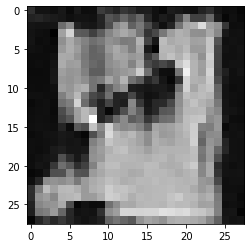

In [ ]:
# show a random one
import matplotlib.pyplot as plt
random_index = 3
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")